In [3]:
import numpy as np
import torch

import gym
import rl_gym


import matplotlib.pyplot as plt



In [9]:
#code from:
#https://towardsdatascience.com/adapting-soft-actor-critic-for-discrete-action-spaces-a20614d4a50a
#https://github.com/Felhof/DiscreteSAC/blob/main/trainer.py

class ReplayBuffer:

    def __init__(self, environment, capacity=5000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count


In [10]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=64)
        self.layer_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.output_layer = torch.nn.Linear(in_features=64, out_features=output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        layer_1_output = torch.nn.functional.relu(self.layer_1(inpt))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        output = self.output_activation(self.output_layer(layer_2_output))
        return output

In [11]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01

    def __init__(self, environment):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n
        self.critic_local = Network(input_dimension=self.state_dim,
                                    output_dimension=self.action_dim)
        self.critic_local2 = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_optimiser = torch.optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = torch.optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)

        self.critic_target = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_target2 = Network(input_dimension=self.state_dim,
                                      output_dimension=self.action_dim)

        self.soft_update_target_networks(tau=1.)

        self.actor_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
            output_activation=torch.nn.Softmax(dim=1)
        )
        self.actor_optimiser = torch.optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)

        self.replay_buffer = ReplayBuffer(self.environment)

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action


    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition):
        # Set all the gradients stored in the optimisers to zero.
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        # Calculate the loss for this transition.
        self.replay_buffer.add_transition(transition)
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network
        # parameters.
        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            # get minibatch of 100 transitions from replay buffer
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE)
            minibatch_separated = list(map(list, zip(*minibatch)))

            # unravel transitions to get states, actions, rewards and next states
            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]), dtype=torch.int64)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            critic_loss, critic2_loss = \
                self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)

            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)

            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)

            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks()

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor):
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            next_q_values_target = self.critic_target.forward(next_states_tensor)
            next_q_values_target2 = self.critic_target2.forward(next_states_tensor)
            soft_state_values = (action_probabilities * (
                    torch.min(next_q_values_target, next_q_values_target2) - self.alpha * log_action_probabilities
            )).sum(dim=1)

            next_q_values = rewards_tensor + ~done_tensor * self.DISCOUNT_RATE*soft_state_values

        soft_q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        soft_q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        critic_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values, next_q_values)
        critic2_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values2, next_q_values)
        weight_update = [min(l1.item(), l2.item()) for l1, l2 in zip(critic_square_error, critic2_square_error)]
        self.replay_buffer.update_weights(weight_update)
        critic_loss = critic_square_error.mean()
        critic2_loss = critic2_square_error.mean()
        return critic_loss, critic2_loss

    def actor_loss(self, states_tensor,):
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values_local = self.critic_local(states_tensor)
        q_values_local2 = self.critic_local2(states_tensor)
        inside_term = self.alpha * log_action_probabilities - torch.min(q_values_local, q_values_local2)
        policy_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return policy_loss, log_action_probabilities

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)



In [12]:

TRAINING_EVALUATION_RATIO = 10
RUNS = 1
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 600

#env = gym.make("CartPole-v1")
env = gym.make("rl_gym/PuckWorld-v0", fps=60)

agent_results = []
for run in range(RUNS):
    agent = SACAgent(env)
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        print('\r', f'Run: {run + 1}/{RUNS} | Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
        evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
        episode_reward = 0
        state = env.reset()
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1
            action = agent.get_next_action(state, evaluation_episode=evaluation_episode)
            next_state, reward, done, info = env.step(action)
            if not evaluation_episode:
                agent.train_on_transition(state, action, next_state, reward, done)
            else:
                episode_reward += reward
            state = next_state
        if evaluation_episode:
            run_results.append(episode_reward)
    agent_results.append(run_results)

env.close()



 Run: 1/1 | Episode: 500/500 

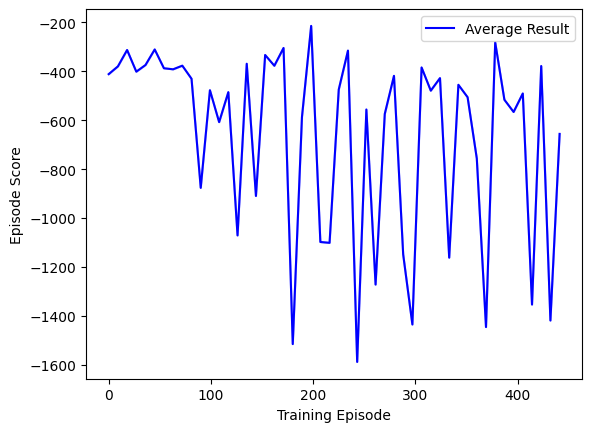

In [8]:
n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

x_vals = list(range(len(results_mean)))
x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

ax = plt.gca()
#ax.set_ylim([0, 200])
ax.set_ylabel('Episode Score')
ax.set_xlabel('Training Episode')
ax.plot(x_vals, results_mean, label='Average Result', color='blue')
ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
plt.legend(loc='best')
plt.show()

In [ ]:
n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

x_vals = list(range(len(results_mean)))
x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

ax = plt.gca()
#ax.set_ylim([0, 200])
ax.set_ylabel('Episode Score')
ax.set_xlabel('Training Episode')
ax.plot(x_vals, results_mean, label='Average Result', color='blue')
ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
plt.legend(loc='best')
plt.show()